# Лабораторная 2

In [1]:
from abc import ABCMeta, abstractmethod
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [19]:
df = pd.read_csv("data\creditcard.csv")

In [20]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [21]:
class Classificator():
    __metaclass__ = ABCMeta
    
    @abstractmethod
    def train(X, Y):
        '''Обучить модель'''
    
    @abstractmethod
    def predict(self, X, tree):
        '''Предсказать данные'''

In [22]:
class RandomClassifier(Classificator):
    predicate = 0
    y = 0
    column = ''
    p = 0
    
    def train(self, X, Y):
        X = X.sample(1, axis=1)
        self.predicate = X.sample(1)
        self.y = Y[self.predicate.index]
        self.column = self.predicate.columns[0]
        self.p = (Y == 1).sum() / len(Y)
        self.predicate = self.predicate[self.column].values[0]
        
    def predict(self, X):
        x = X.copy()
        x['target'] = [0] * len(x)
        x.loc[x[self.column] <= self.predicate, 'target'] = self.p
        x.loc[x[self.column] > self.predicate, 'target'] = 1 - self.p
        return x.target
        

In [23]:
class DecisionTree(Classificator):
    
    def train(self, X, Y, tabs="", depth = 0, max_depth=None, min_leaf=1, random_features=False):
        entropy = self.calculate_entropy(Y)
        node = {}
        if entropy == 0 or depth == max_depth or len(X) <= min_leaf or len(X.columns) == 0:
            p = 0
            if len(Y.loc[Y != 1]) == 0:
                p = 1
            elif len(Y.loc[Y == 1]) == 0:
                p = 0
            else:
                p = len(Y.loc[Y == 1]) / len(Y)
            node['label'] = p
            return node
        
        if random_features == True:
            X = X.sample(int(np.sqrt(len(X.columns))), axis=1)
        
        igs = []
        for index, row in X.iterrows():
            inner_igs = []
            for column in X:
                predicate = row[column]
                left = X[column].loc[X[column] <= predicate]
                right = X[column].loc[X[column] > predicate]
                Y_left = Y.loc[left.index]
                Y_right = Y.loc[right.index]
                groups = [[len(left), self.calculate_entropy(Y_left)], [len(right), self.calculate_entropy(Y_right)]]
                ig = self.information_gain(Y, entropy, groups)
                inner_igs.append(Predicate(column, ig, predicate))
            igs.append(self.get_max_ig(inner_igs))

        predicate = self.get_max_ig(igs)
        
        
        X_left = X.loc[X[predicate.attribute] <= predicate.predicate].drop(predicate.attribute, axis=1)
        X_right = X.loc[X[predicate.attribute] > predicate.predicate].drop(predicate.attribute, axis=1)
        Y_left = Y.loc[X_left.index]
        Y_right = Y.loc[X_right.index]
        depth += 1
        node['attribute'] = predicate.attribute
        node['value'] = predicate.predicate
        node['nodes'] = {}
        node['nodes']['<='] = DecisionTree().train(X_left, Y_left, depth=depth, max_depth=max_depth, min_leaf=min_leaf, random_features=random_features)
        node['nodes']['>'] = DecisionTree().train(X_right, Y_right, depth=depth, max_depth=max_depth, min_leaf=min_leaf, random_features=random_features)
        return node
    
    def predict(self, X, tree):
        x = X.copy()
        x['target'] = [0] * len(x)
        return self.set_label(x, tree).target
    
    def set_label(self, X, tree):
        if 'label' in tree:
            X.target = tree['label']
            return X
        left = X.loc[X[tree['attribute']] <= tree['value']]
        X.loc[X[tree['attribute']] <= tree['value']] = self.set_label(left, tree['nodes']['<='])
        right = X.loc[X[tree['attribute']] > tree['value']]
        X.loc[X[tree['attribute']] > tree['value']] = self.set_label(right, tree['nodes']['>'])
        return X
    
    def calculate_entropy(self, Y):
        count = len(Y)
        entropy = 0
        for count_class in Y.value_counts():
            p = count_class / count
            entropy -= p * np.log2(p)
        return entropy
    
    
    def information_gain(self, Y, entropy0, groups):
        N = len(Y)
        sum_entropies = 0
        for group in groups:
            group
            Ni = group[0]
            Si = group[1]
            sum_entropies += Ni / N * Si
        return entropy0 - sum_entropies
    
    def get_max_ig(self, igs):
        information_gain = igs[0]
        for ig in igs:
            if ig.ig > information_gain.ig:
                information_gain = ig
        return information_gain

In [24]:
class RandomForest(Classificator):
    tree = DecisionTree()
    model = []
    
    def train(self, X, Y, N=10, max_depth=None, min_leaf=1):
        for i in range(N):
            Xn = X.sample(int(len(X) * 2 / 3), replace=True)
            Yn = Y.loc[Xn.index]
            self.model.append(self.tree.train(Xn, Yn, max_depth=max_depth, min_leaf=min_leaf, random_features=True))
        return self.model
    
    def predict(self, X):
        prediction_list = []
        res = []
        for m in self.model:
            prediction_list.append(self.tree.predict(X, tree=m))
        for i in prediction_list[0].index:
            label = 0
            for t in prediction_list:
                label += t[i]
            label /= len(prediction_list)
            res.append(label)
        return res

In [25]:
from sklearn.tree import DecisionTreeRegressor

class GradientBoosting(Classificator):
    model = DecisionTreeRegressor()
    
    def train(self, X, Y, M, max_depth=None, alpha=0.2, min_leaf=1):
        y = Y.copy()
        x = X.copy()
        x = x.reset_index(drop=True)
        y = y.reset_index(drop=True)
        y.loc[y == 0] = -1
        F = [[0] * len(y)]
        for t in range(1, M):
            r = 2 * y / (1 + np.exp(2 * y * F[t - 1]))
            h = DecisionTreeRegressor(max_depth=max_depth, min_samples_leaf=min_leaf)
            h.fit(X, r)
            F.append(alpha * h.predict(X))
            F[t] += F[t - 1]
        self.model.fit(X, F[M - 1])
    
    def predict(self, X):
        return 1 / (1 + np.exp(-self.model.predict(X)))

In [37]:
import matplotlib.pyplot as plt

class ROC_AUC():
    models = []
    labels = []
    
    def __init__(self, models, labels):
        self.models = models
        self.labels = labels
        
    def show(self):
        curves = []
        for i in range(len(self.models)):
            fpr, tpr, auc = self.roc_curve(self.models[i][0], self.models[i][1])
            self.labels[i] += " (AUC = " + str(round(auc, 2)) + ")"
            plt.plot(fpr, tpr)
        plt.plot([0, 1], [0, 1])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(self.labels)
        plt.show()
    
    
    def roc_curve(self, y_true, y_score):
        y = pd.DataFrame({'true' : y_true, 'score' : y_score})
        y = y.sort_values('score', ascending=False).reset_index(drop=True)
        m = len(y)
        m0 = (y.true == 0).sum()
        m1 = (y.true == 1).sum()
        FPR, TPR = ([0], [0])
        AUC = 0
        for i in range(1, m + 1):
            if y.true[i - 1] == 0:
                FPR.append(FPR[i - 1] + 1 / m0)
                TPR.append(TPR[i - 1])
                AUC += TPR[i] / m0
            else:
                FPR.append(FPR[i - 1])
                TPR.append(TPR[i - 1] + 1 / m1)
        return (FPR, TPR, AUC)

In [27]:
def read_tree(t, tabs='', d=''):
    print(tabs+'predicate: ' + d)
    if 'label' in t:
        print(tabs+'label: ' + str(t['label']))
    else:
        print(tabs+'attr: ' + t['attribute'])
        print(tabs+'val: ' + str(t['value']))
        read_tree(t['nodes']['<='], tabs+'\t', d='<=')
        read_tree(t['nodes']['>'], tabs+'\t', d='>')
    return

In [28]:
class Predicate:
    attribute = ""
    ig = 0
    predicate = 0
    
    def __init__(self, attribute, ig, predicate):
        self.attribute = attribute
        self.ig = ig
        self.predicate = predicate

In [29]:
models = []

In [30]:
temp0 = df.loc[df.Class == 1]
temp1 = df.loc[df.Class == 0].sample(n = 3000)
temp = pd.concat([temp0, temp1]).reset_index(drop=True)

In [31]:
X = temp[temp.columns[:-1]]
y = temp.Class

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
X = df[df.columns[:-1]]
y = df.target

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
random = RandomClassifier()
random.train(X_train, Y_train)
predicted = random.predict(X_test)
models.append([Y_test, predicted])

In [33]:
tree = DecisionTree()
t = tree.train(X_train, Y_train, min_leaf=1000)
predicted = tree.predict(X_test, t)
models.append([Y_test, predicted])

In [34]:
forest = RandomForest()
f = forest.train(X_train, Y_train, N=20, min_leaf=1000)
predicted = forest.predict(X_test)
models.append([Y_test, predicted])

In [48]:
gbm = GradientBoosting()
gbm.train(X_train, Y_train, M=1000, min_leaf=1000)
predicted = gbm.predict(X_test)
models.append([Y_test, predicted])

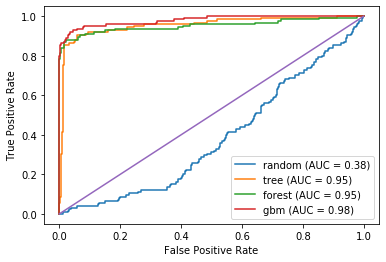

In [49]:
roc_auc = ROC_AUC(models, ['random', 'tree', 'forest',  'gbm'])
roc_auc.show()